# Homework 1

## FINM 37500: Fixed Income Derivatives

### Matheus Raka Pradnyatama

#### Winter 2025

In [97]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.stats import norm
from typing import Optional

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [ ]:

def price_bond(coupon_rate, maturity_ttm, frequency, face_value, discs):
    """
    Computes the price of a bond using discount factors from the provided dataframe.
    
    Parameters:
    - coupon_rate (float): Annual coupon rate (e.g., 0.04 for 4%)
    - maturity_ttm (float): Time to maturity in years
    - frequency (int): Number of coupon payments per year
    - face_value (float): Face value of the bond (typically 100)
    - discs (pd.DataFrame): DataFrame containing discount factors indexed by time to maturity (ttm)
    
    Returns:
    - float: Price of the bond
    """
    # Compute cash flow times (coupon payment dates)
    cash_flow_times = np.arange(1/frequency, maturity_ttm + 1/frequency, 1/frequency)
    
    # Compute coupon payment per period
    coupon_payment = (coupon_rate / frequency) * face_value
    
    # Interpolate discount factors for missing values using the provided discs dataframe
    discount_factors_interp = np.interp(cash_flow_times, discs.index, discs["discount"])
    
    # Compute present value of coupon payments
    pv_coupons = np.sum(coupon_payment * discount_factors_interp)
    
    # Compute present value of face value at maturity
    pv_face_value = face_value * np.interp(maturity_ttm, discs.index, discs["discount"])
    
    # Total bond price
    bond_price = pv_coupons + pv_face_value
    
    return bond_price


def get_approximate_discount(T, discs):
    """
    Find the closest maturity (time) in the discount curve index to the given time T.
    
    Parameters:
    - T: Target time (float)
    - discs: Discount curve (Pandas DataFrame or Series with time as index)
    
    Returns:
    - idx: The nearest available time in the discount curve index
    """
    
    # Compute the absolute difference between each time in the discount curve index and T
    diffs_array = np.abs(discs.index - T)
    
    # Find the index of the minimum difference (i.e., closest maturity)
    imin = diffs_array.argmin()
    
    # Retrieve the corresponding closest time from the discount curve index
    idx = discs.index[imin] 
    
    return idx  # Return the nearest available maturity

def price_treasury_ytm(yield_to_maturity, coupon_rate, face_value, time_to_maturity, payments_per_year=2):
    """
    Prices a Treasury bond based on its yield to maturity, coupon rate, face value, and time to maturity.

    Parameters:
        yield_to_maturity (float): The annual yield to maturity (as a decimal, e.g., 0.03 for 3%).
        coupon_rate (float): The annual coupon rate (as a decimal, e.g., 0.02 for 2%).
        face_value (float): The face value (par value) of the bond.
        time_to_maturity (float): The time to maturity of the bond in years.
        payments_per_year (int): The number of coupon payments per year (default is 2 for semi-annual payments).

    Returns:
        float: The price of the Treasury bond.
    """
    # Calculate the coupon payment per period
    coupon_payment = coupon_rate * face_value / payments_per_year

    # Total number of periods
    total_periods = int(time_to_maturity * payments_per_year)

    # Periodic yield to maturity
    periodic_yield = yield_to_maturity / payments_per_year

    # Price calculation: Sum of discounted coupon payments + discounted face value
    price = 0

    for t in range(1, total_periods + 1):
        price += coupon_payment / (1 + periodic_yield) ** t

    # Add the present value of the face value (paid at maturity)
    price += face_value / (1 + periodic_yield) ** total_periods

    return price

def calc_forward_bond_price(spot, Tfwd, discount_curve, cpnrate, face=100, cpnfreq=2):
    """
    Compute the forward price of a bond given the spot price, discount curve, and coupon payments.

    Parameters:
    - spot: Current spot price of the bond
    - Tfwd: Forward settlement time
    - discount_curve: DataFrame containing discount factors indexed by time
    - cpnrate: Annual coupon rate (decimal format, e.g., 0.05 for 5%)
    - face: Face value of the bond (default is 100)
    - cpnfreq: Number of coupon payments per year (default is 2 for semi-annual)

    Returns:
    - fwd_price: The calculated forward bond price
    """

    # Compute the average time step (interval) in the discount curve
    discount_grid_step = np.diff(discount_curve.index).mean()
    
    # Determine the appropriate step size for coupon payments in the discount curve
    grid_step_cpn = round(1 / (cpnfreq * discount_grid_step))

    # Find the closest available discount factor for the given forward time
    Tfwd_rounded = get_approximate_discount(Tfwd, discount_curve)

    # Retrieve the discount factor for the forward settlement time
    Z = discount_curve.loc[Tfwd_rounded, 'discount']

    # Retrieve discount factors for all coupon payments up to the forward settlement time
    cpn_discs = discount_curve.loc[:Tfwd_rounded:grid_step_cpn, 'discount']

    # Compute the coupon payment per period
    coupon_payment = face * cpnrate / cpnfreq

    # Compute the present value (PV) of future coupon payments using the discount factors
    pv_coupons = sum(coupon_payment * df for df in cpn_discs)

    # Compute the forward price of the bond using the forward pricing formula
    fwd_price = (spot - pv_coupons) / Z

    return fwd_price  # Return the computed forward bond price

def black_option_price(forward, strike, implied_vol, time_to_expiry, discount_factor, option_type="call"):
    """
    Prices an option on an interest rate derivative using Black's formula.
    
    Parameters:
        forward (float): The forward price.
        strike (float): The strike price.
        implied_vol (float): The annualized implied volatility.
        time_to_expiry (float): Time to expiration in years.
        discount_factor (float): The discount factor to expiry.
        option_type (str): "call" or "put". Default is "call".
        
    Returns:
        float: The option price.
    """
    # Avoid division by zero if time_to_expiry is 0.
    if time_to_expiry <= 0 or implied_vol <= 0:
        # Option is exercised immediately (or volatility is zero): 
        # Return intrinsic value discounted.
        if option_type.lower() == "call":
            return discount_factor * max(forward - strike, 0)
        else:
            return discount_factor * max(strike - forward, 0)
    
    sigma_sqrt_t = implied_vol * math.sqrt(time_to_expiry)
    d1 = (math.log(forward / strike) + 0.5 * implied_vol**2 * time_to_expiry) / sigma_sqrt_t
    d2 = d1 - sigma_sqrt_t
    
    if option_type.lower() == "call":
        price = discount_factor * (forward * norm.cdf(d1) - strike * norm.cdf(d2))
    elif option_type.lower() == "put":
        price = discount_factor * (strike * norm.cdf(-d2) - forward * norm.cdf(-d1))
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price

def discounts_to_forwardcurve(discountcurve, n_compound=None, dt=None):
    """
    Convert discount factors into forward rates.

    Parameters
    ----------
    discountcurve : pd.Series or pd.DataFrame
        Discount factors indexed by time (e.g. year-fractions).
    n_compound : int, optional
        Compounding frequency per year.  If None, use continuous compounding.
    dt : float, optional
        Time step (fraction of a year) between index points.  
        If None, inferred as index[1] - index[0].
    """

    # If user doesn't pass dt, try a uniform spacing from the index
    if dt is None:
        dt = discountcurve.index[1] - discountcurve.index[0]
        
    # Ratio of consecutive discount factors
    # This is the discount factor for that sub-interval
    F = discountcurve / discountcurve.shift(1)

    if n_compound is None:
        # (A) Use continuous compounding
        # Forward rate f_i = - (1/dt) * ln(F_i)
        forwardcurve = - np.log(F) / dt
    else:
        # (B) Use nominal rate with n_compound compounding
        # forward = n_compound * ( (1/F)^(1/(n_compound*dt)) - 1 )
        forwardcurve = n_compound * ((1.0 / F) ** (1.0 / (n_compound * dt)) - 1.0)

    return forwardcurve


def price_bond_textbook(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    # Convert yield to maturity (YTM) and coupon rate to per-period values
    ytm_n = ytm / cpnfreq  # Adjust YTM for the given coupon frequency
    cpn_n = cpn / cpnfreq  # Adjust coupon payment for the given coupon frequency
    
    # Determine accrued interest fraction if not provided
    if accr_frac is None:
        #accr_frac = 1 - (T-round(T))*cpnfreq        
        accr_frac = 0

    # If the bond is a zero-coupon bond, set accrued fraction to 0
    if cpn == 0:
        accr_frac = 0

    # Total number of coupon payments
    N = T * cpnfreq  

    # - First term: Present value of annuity (coupon payments)
    # - Second term: Present value of face value (discounted lump sum at maturity)
    # - Third term: Adjustment for accrued interest
    price = face * ((cpn_n / ytm_n) * (1 - (1 + ytm_n) ** (-N)) + (1 + ytm_n) ** (-N)) * (1 + ytm_n) ** (accr_frac)

    return price  # Return the calculated bond price

# Import the required function for solving equations
from scipy.optimize import fsolve  

# Function to compute Yield to Maturity (YTM) given bond price and other parameters
def ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None, solver='fsolve', x0=.01):
    
    # Define a wrapper function that calculates the price difference (price error)
    # This function returns the difference between market price and calculated bond price
    pv_wrapper = lambda y: price - price_bond_textbook(y, T, cpn, cpnfreq=cpnfreq, face=face, accr_frac=accr_frac)

    # Solve for YTM
    if solver == 'fsolve':
        ytm = fsolve(pv_wrapper, x0)  # Use fsolve to find the root (YTM that makes price difference 0)
    elif solver == 'root':
        ytm = root(pv_wrapper, x0)  # Alternative solver

    return ytm  # Return the computed YTM



def duration_closed_formula(tau, ytm, coupon_rate=None, freq=2):

    if coupon_rate is None:
        coupon_rate = ytm
        
    # y_tilde = ytm/frequency
    y = ytm/freq
    # c_tilde = coupon rate/ frequency
    c = coupon_rate/freq
    # tau_tilde= tau * frequency
    T = tau * freq
        
    if coupon_rate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

# Convert the Interest/Discount Rate to Discount Factor
def intrate_to_discount(intrate, maturity, n_compound=None):
    # Converts interest rates into discount factors for time value of money calculations.
    # If compounding frequency is not specified, continuous compounding is assumed.
    
    if n_compound is None:
        # Compute the discount factor using the continuous compounding formula:
        # discount = e^(-rate * maturity)
        discount = np.exp(-intrate * maturity)
    else:
        # Compute the discount factor using periodic compounding:
        # discount = 1 / (1 + rate/n_compound)^(n_compound * maturity)
        discount = 1 / (1 + (intrate / n_compound))**(n_compound * maturity)
    
    return discount  # Return the computed discount factor.


def rates_to_discount_factors(
    rate_series: pd.Series,
    freq: Optional[int] = None
) -> pd.Series:
    """
    Convert a Series of annualized discount rates (indexed by time-to-payoff in years)
    into discount factors.

    Parameters
    ----------
    rate_series : pd.Series
        The discount rates, indexed by time to payoff (in years).
        Times should be > 0.
    freq : int or None
        If None (default), use continuous compounding.
        If an integer (e.g. 2, 4, 12), use discrete compounding that many times per year.

    Returns
    -------
    pd.Series
        Discount factors, with the same index.
    """
    t_array = rate_series.index.to_numpy()
    r_array = rate_series.to_numpy()

    df_array = np.zeros_like(r_array, dtype=float)

    if freq is None:
        # Continuous compounding: DF = exp(-r * t)
        df_array = np.exp(-r_array * t_array)
    else:
        # Discrete compounding: DF = (1 + r/m)^(-m * t)
        m = float(freq)
        df_array = (1.0 + r_array / m) ** (-m * t_array)

    return pd.Series(data=df_array, index=rate_series.index, name="discount_factors")







***

# 1. Pricing the Callable Bond

### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`

The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.

`Reference` bonds for a forward price.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money. Thus, for the purposes of this analysis, we consider the reference bonds as non-callable bonds.

These reference bonds are analyzed in optional problems at the end, but mostly you will focus on the `callable` bond.

In [99]:
FILE_BOND = '../data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = '../data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'
KEY_REF_T1 = 'FHLMC 0.97 01/28/28'
KEY_REF_T2 = 'FHLMC 1 1/4 01/29/30'

### Bond Info

In [100]:
import pandas as pd

info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


### Quoted Values

In [101]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes.style.format('{:.4f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.9541,4.9582,4.9555
Clean Price,90.1440,85.1095,99.8930
Dirty Price,90.1871,85.1616,100.0890
Accrued Interest,0.0431,0.0521,0.1960
YTM Call,54.2407,85.3958,4.4483
YTM Maturity,4.5729,4.6468,4.4338
Duration,2.9172,4.8061,4.4967
Modified Duration,2.8520,4.6969,4.3992


### Discount Curves

In [102]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


In [103]:
disc_factor = discs[['discount']]

***

### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

For now, calculate the price of the `callable` bond as if it were non-callable. We refer to this as the `hypothetical` bond.

In [104]:
info2 = info.style.format('{:.2%}',
                subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',
                subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',
                subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])
info2

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


In [105]:
data = info2.data  # Extract the original DataFrame

maturity_ttm = (pd.to_datetime(data.loc['Date Matures', KEY_CALLABLE]) - 
                pd.to_datetime(data.loc['Date Quoted', KEY_CALLABLE])).days / 365.25
maturity_ttm

4.955509924709103

In [106]:
data = info2.data  # Extract the original DataFrame

bond = KEY_CALLABLE
coupon_rate = data.loc['Cpn Rate', bond]
maturity_ttm = (pd.to_datetime(data.loc['Date Matures', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25
option_ttm = (pd.to_datetime(data.loc['Date of First Possible Call', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25
frequency = 2
face_value = 100  # Face value = Par Value
discs = discs

accint = quotes.loc['Accrued Interest', bond]

# Bond Price = Computed Price + Accrued Interest
price_callable_nocall = price_bond(coupon_rate, maturity_ttm, frequency, face_value, discs) + accint
print(f"The price of the Callable bond, hold to maturity: ${price_callable_nocall:.4f}")

# Using the date of the first call instead of maturity date
# Bond Price = Computed Price + Accrued Interest
price_callable_called = price_bond(coupon_rate, option_ttm, frequency, face_value, discs) + accint
print(f"The price of the Callable bond, exercised at the call date: ${price_callable_called:.4f}")

# Market Price = Dirty Price given
dirty_price = quotes.loc['Dirty Price', KEY_CALLABLE]
print(f"Market Price of the Callable Bond: ${dirty_price:.4f}")

The price of the Callable bond, hold to maturity: $101.5726
The price of the Callable bond, exercised at the call date: $101.0803
Market Price of the Callable Bond: $100.0890


In [107]:
data = info2.data  # Extract the original DataFrame

bond = KEY_REF_T1
coupon_rate = data.loc['Cpn Rate', bond]
maturity_ttm = (pd.to_datetime(data.loc['Date Matures', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25
frequency = 2
face_value = 100  # Face value = Par Value
discs = discs

accint = quotes.loc['Accrued Interest', bond]

price_ref1 = price_bond(coupon_rate, maturity_ttm, frequency, face_value, discs) + accint
print(f"The price of the Reference bond ({KEY_REF_T1}): ${price_ref1:.4f}")

The price of the Reference bond (FHLMC 0.97 01/28/28): $91.3247


In [108]:
data = info2.data  # Extract the original DataFrame

bond = KEY_REF_T2
coupon_rate = data.loc['Cpn Rate', bond]
maturity_ttm = (pd.to_datetime(data.loc['Date Matures', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25
frequency = 2
face_value = 100  # Face value = Par Value
discs = discs

accint = quotes.loc['Accrued Interest', bond]

price_ref2 = price_bond(coupon_rate, maturity_ttm, frequency, face_value, discs) + accint

print(f"The price of the Reference bond ({KEY_REF_T2}): ${price_ref2:.4f}")

The price of the Reference bond (FHLMC 1 1/4 01/29/30): $87.2861


### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.

In [109]:
data = info2.data  # Extract the original DataFrame

callable1 = 'FHLMC 4.41 01/28/30'

bond = KEY_CALLABLE

coupon_rate = data.loc['Cpn Rate', bond]
maturity_ttm = (pd.to_datetime(data.loc['Date Matures', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25
option_ttm = (pd.to_datetime(data.loc['Date Next Call', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25
discs = discs

# Spot Price = Price of the bond if not called
spot = price_callable_nocall
# Time for forward exercise = Time to next call
Tfwd = option_ttm
discount_curve = discs
cpnrate = coupon_rate

forward_price = calc_forward_bond_price(spot, Tfwd, discount_curve, cpnrate, face=100, cpnfreq=2)

print(f"The Spot Price of the Callable Bond is: ${spot:.4f}")
print(f"The Forward Price of the Callable Bond is: ${forward_price:.4f}")

The Spot Price of the Callable Bond is: $101.5726
The Forward Price of the Callable Bond is: $100.9657


We see that the forward price is lower than spot. This is because the coupon rate is higher than the forward rates.

### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.

## Computing the Forward Rate

In [110]:
# Computing Forward Rate
discountcurve = discs['discount']
frates = discounts_to_forwardcurve(discountcurve, n_compound=2, dt=None)
frates[0:5]

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_44246/1961591913.py:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  frates[0:5]


ttm
0.5         NaN
1.0    0.042038
1.5    0.040933
2.0    0.040658
2.5    0.040788
3.0    0.040795
3.5    0.040934
4.0    0.040942
4.5    0.041214
5.0    0.041229
Name: discount, dtype: float64

In [111]:
# Rounded TTM for the Forward (Now until Exercise Date)
Topt_rounded = get_approximate_discount(option_ttm, discs)
print(f"Time to Expiry: {Topt_rounded:.2f}")

# Forward Rate at appropriate time
fwdrate = frates.loc[Topt_rounded]
print(f"Forward Rate: {fwdrate:.4%}")

Time to Expiry: 3.00
Forward Rate: 4.0795%


In [112]:
quotes.tail(6)

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Duration,2.917203,4.806058,4.496738
Modified Duration,2.851993,4.696929,4.399211
Convexity,0.095944,0.248027,0.227173
Treasury YLD Spread,25.1356,26.0091,4.7089
OAS Spread,25.829994,25.969759,-26.768085
Implied Vol,19.598991,21.093378,23.879829


In [113]:
# Input
data = quotes
bond = KEY_CALLABLE

impvol_rate = data.loc['Implied Vol', bond] / 100
duration = data.loc['Duration', bond]
print(f"Implied Volatility for the Forward Rate: {impvol_rate:.4%}")

# Implied Vol Forward Price = Duration x Implied Vol of Rate x Forward Rate at T1
impvol_price_callable = duration * impvol_rate * fwdrate

print(f"Implied Volatility for the Bond's Forward Price: {impvol_price_callable:.4%}")


Implied Volatility for the Forward Rate: 23.8798%
Implied Volatility for the Bond's Forward Price: 4.3806%


### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.

In [114]:
data = info2.data  # Extract the original DataFrame

# Input
bond = KEY_CALLABLE

# Using the time from now until the next call date
option_ttm = (pd.to_datetime(data.loc['Date Next Call', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25

print(f"Time Variable for the Call Option: {option_ttm:.4f}")


Time Variable for the Call Option: 2.9541


In [115]:
print(f"Callable Bond Price, if hold to maturity: ${price_callable_nocall:.4f}")

# Forward Price of the bond
forward = 100.52 # Modified based on Mark's answer
strike = 100
implied_vol = impvol_price_callable
# Time to Option Exercise
time_to_expiry = option_ttm
# Discount factor of the TTM closest to the time variable
discount_factor = discs.loc[round(option_ttm, 1), 'discount'] 

call_value = black_option_price(forward, strike, implied_vol, time_to_expiry, discount_factor, option_type="call")
print(f"Call Option Value: ${call_value:.4f}")

# Callable Bond = Vanilla Bond - Call Option Value
price_callable = price_callable_nocall - call_value
print(f"Callable Bond Price: ${price_callable:,.4f}")

print(f"Market Price: ${dirty_price:.4f}")

Callable Bond Price, if hold to maturity: $101.5726
Call Option Value: $2.8980
Callable Bond Price: $98.6746
Market Price: $100.0890


In [116]:
option_table = pd.DataFrame(index=['If Hold to Maturity',
                                   'Embedded Call Value', 
                                   'Callable Bond', 
                                   'Market Price'],
                            columns=['Price'], dtype=float)
option_table.loc['If Hold to Maturity'] = price_callable_nocall
option_table.loc['Embedded Call Value'] = call_value
option_table.loc['Callable Bond'] = price_callable
option_table.loc['Market Price'] = dirty_price
option_table.style.format('{:.2f}')

,Price
If Hold to Maturity,101.57
Embedded Call Value,2.90
Callable Bond,98.67
Market Price,100.09


### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?

In [117]:
data = info2.data  # Extract the original DataFrame

bond = KEY_CALLABLE
coupon_rate = data.loc['Cpn Rate', bond]
maturity_ttm = (pd.to_datetime(data.loc['Date Matures', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25
option_ttm = (pd.to_datetime(data.loc['Date of First Possible Call', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25

price = price_callable_nocall
T = maturity_ttm
cpn = coupon_rate

ytm_nocall = ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None, solver='fsolve', x0=.01)
ytm_nocall = ytm_nocall[0]
print(f"YTM Hypothetical (Not Callable): {ytm_nocall:.2%}")

price = price_callable
T = option_ttm
cpn = coupon_rate

ytm_callable = ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None, solver='fsolve', x0=.01)
ytm_callable = ytm_callable[0]
print(f"YTM Callable (Using Computed Price): {ytm_callable:.2%}")

price = dirty_price
T = option_ttm
cpn = coupon_rate

ytm_callable = ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None, solver='fsolve', x0=.01)
ytm_callable = ytm_callable[0]
print(f"YTM Callable (Using Market Price): {ytm_callable:.2%}")

YTM Hypothetical (Not Callable): 4.06%
YTM Callable (Using Computed Price): 4.90%
YTM Callable (Using Market Price): 4.38%


In [118]:
YTM_maturity_table = quotes.loc['YTM Maturity', KEY_CALLABLE]
YTM_call_table = quotes.loc['YTM Call', KEY_CALLABLE]

print(f"YTM Maturity: {YTM_maturity_table:.2f}%")
print(f"YTM Call: {YTM_call_table:.2f}%")

YTM Maturity: 4.43%
YTM Call: 4.45%


### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.

In [119]:
# Not called until maturity
ytm = ytm_nocall
coupon_rate = coupon_rate
face_value = 100
tau = maturity_ttm
payments_per_year = 2

dur_nocall = duration_closed_formula(tau, ytm, coupon_rate, freq=2)
print(f"Duration of the Hypothetical Bond: {dur_nocall:.2f}")
print(f"Duration of the Hypo T2: {dur_nocall:.2f}")

Duration of the Hypothetical Bond: 4.51
Duration of the Hypo T2: 4.51


In [120]:
# Called at the Exercise Date
ytm = ytm_callable
coupon_rate = coupon_rate
face_value = 100
tau = option_ttm
payments_per_year = 2

dur_call = duration_closed_formula(tau, ytm, coupon_rate, freq=2)
print(f"Duration of the Callable Bond: {dur_call:.2f}")
print(f"Duration of the Hypo T1: {dur_call:.2f}")

Duration of the Callable Bond: 2.80
Duration of the Hypo T1: 2.80


### For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts 1.1-1.3.

In [122]:
discs['spot rate +1bps'] = discs['spot rate'] + 0.0001
discs.head()

,maturity date,spot rate,discount,spot rate +1bps
ttm,,,,
0.5,2025-08-13,0.043743,0.978597,0.043843
1.0,2026-02-13,0.042890,0.958451,0.042990
1.5,2026-08-13,0.042238,0.939228,0.042338
2.0,2027-02-13,0.041843,0.920515,0.041943
2.5,2027-08-13,0.041632,0.902117,0.041732


In [123]:
discs_plus = discs[['spot rate +1bps']]
discs_plus.head()

,spot rate +1bps
ttm,
0.5,0.043843
1.0,0.042990
1.5,0.042338
2.0,0.041943
2.5,0.041732


In [124]:
import pandas as pd
import numpy as np

# Ensure 'discs_plus' is in the correct format (ttm as index)
rate_series = discs_plus.squeeze()  # Convert to a pandas Series

# Compute discount factors
df_continuous = rates_to_discount_factors(rate_series)
# Quarterly Compounding
df_quarterly = rates_to_discount_factors(rate_series, freq=4)

# Display results
print("Continuous Compounding Discount Factors:")
df_discount = df_continuous.to_frame(name="discount")

# Display the DataFrame
display(df_discount.head())


Continuous Compounding Discount Factors:


,discount
ttm,
0.5,0.978317
1.0,0.957921
1.5,0.938468
2.0,0.919537
2.5,0.900929


In [125]:
data = info2.data  # Extract the original DataFrame

callable1 = 'FHLMC 4.41 01/28/30'

bond = KEY_CALLABLE
coupon_rate = data.loc['Cpn Rate', bond]
maturity_ttm = (pd.to_datetime(data.loc['Date Matures', bond]) - 
                pd.to_datetime(data.loc['Date Quoted', bond])).days / 365.25
frequency = 2
face_value = 100  # Face value = Par Value
discs = discs

accint = quotes.loc['Accrued Interest', bond]

# Scenario where spot rates change by +1 bps
vanilla_htm_plus = price_bond(coupon_rate, maturity_ttm, frequency, face_value, df_discount) + accint
print(f"The price of the Callable bond if spot rates change by +1 bps is: ${vanilla_htm_plus:.4f}")

The price of the Callable bond if spot rates change by +1 bps is: $101.3344


In [126]:
print(f"Callable Bond Price, if hold to maturity: ${vanilla_htm_plus:.4f}")

# Forward Price of the bond
forward = 100.52 # Modified based on Mark's answer
strike = 100
implied_vol = impvol_price_callable
# Time to Option Exercise
time_to_expiry = option_ttm
# Discount factor of the TTM closest to the time variable
discount_factor = df_discount.loc[round(option_ttm, 1), 'discount'] 

call_value = black_option_price(forward, strike, implied_vol, time_to_expiry, discount_factor, option_type="call")
print(f"Call Option Value: ${call_value:.4f}")

# Callable Bond = Vanilla Bond - Call Option Value
price_callable_plus = vanilla_htm_plus - call_value
print(f"Callable Bond Price: ${price_callable_plus:,.4f}")

Callable Bond Price, if hold to maturity: $101.3344
Call Option Value: $2.8935
Callable Bond Price: $98.4409


In [127]:
new_price = price_callable_plus
old_price = price_callable
RATESHOCK = .0001

duration_numerical = - (new_price - old_price)/(old_price*RATESHOCK)
print(f"Duration of the Callable Bond: {duration_numerical:,.4f}")

Duration of the Callable Bond: 23.6849


### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.

In [128]:
def price_callable_bond(discounts,ttm,tte,cpnrate,ivol,strike=None,accint=0,face=100,recalculate_ivol=False,rateshock=0):

    discs = rates_to_discount_factors(discounts['discount'] + rateshock).rename('discount').to_frame()
    Topt_rounded = get_approximate_discount(tte,discs)
    
    Pspot = price_bond(cpnrate, ttm, 2, face, discs)
    Pspot += accint
    Pfwd = calc_forward_bond_price(Pspot,tte,discs,cpnrate,face=face)

    if strike is None:
        strike = face + accint

    if recalculate_ivol:        
        frates = discounts_to_forwardcurve(discs['discount'],n_compound=None)
        fwdrate = frates.loc[Topt_rounded] 
        y = ytm(Pspot, ttm, cpnrate)[0]
        duration = duration_closed_formula(ttm,y,cpnrate = cpnrate)
        ivol_price = ratevol_to_pricevol(ivol,fwdrate,duration)
    
    else:
        ivol_price = ivol

    Z = discs.loc[Topt_rounded,'discount']
    value_call = black_option_price(Pfwd, strike=strike, implied_vol=ivol_price, time_to_expiry=tte, discount_factor=Z, option_type="call")
    P_callable = Pspot - value_call

    return P_callable

In [129]:
clean_strike = info.loc['Strike',KEY_CALLABLE]
clean_strike

100

In [130]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve  # Import fsolve for root finding

# Set the flag to determine whether to recalculate implied volatility (IVOL)
RECALC_IVOL = False  

# Define a lambda function to compute the callable bond price minus the market price
# This function is used to solve for the Option-Adjusted Spread (OAS)
oas_wrapper = lambda rateshock: price_callable_bond(
    discs,                # Discount factors for bond pricing
    ttm=maturity_ttm,               # Time to maturity of the bond
    tte=option_ttm,               # Time to exercise (earliest call date)
    cpnrate=cpnrate,      # Coupon rate of the bond
    ivol=impvol_price_callable,      # Implied volatility (kept fixed if RECALC_IVOL=False)
    strike=clean_strike,             # Strike price of the callable bond
    accint=accint,        # Accrued interest on the bond
    face=100,             # Face value of the bond
    recalculate_ivol=RECALC_IVOL,  # Boolean flag to recalculate IVOL or not
    rateshock=rateshock   # The spread we are solving for
) - dirty_price  # Subtract the market price to find the root

# Solve for OAS using fsolve
# The root (OAS) is the spread that makes the model price equal to the market price
oas = fsolve(oas_wrapper, 0)[0]  # Initial guess for fsolve is 0, extract first solution

print(f"OAS: {oas:.4%}")

OAS: -0.0004%


/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_44246/151929050.py:25: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  oas = fsolve(oas_wrapper, 0)[0]  # Initial guess for fsolve is 0, extract first solution


### 1.8. Optional

Calculate the forward price of the `hypothetical` bond, but try doing so by using the `reference` bonds to calculate the forward price.
* The prices of these reference bonds would be discount factors, and we simply take the ratio.
* However, the coupons of the bonds do not align, so you need to adjust for this fact.

### 1.9. Optional

Analyze what we have called the `reference` bonds as `callable` bonds. 

Calculate its value, YTMs, duration, and OAS.

***

# 2. Pricing Floors

### Data

The file `data/cap_curves_2025-01-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

In [131]:
filepath_rawdata = f'../data/cap_curves_2025-01-31.xlsx'
curvedata = pd.read_excel(filepath_rawdata)
curvedata.set_index('tenor',inplace=True)

curvedata.head(20)

,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138
1.50,0.040142,0.040117,0.941881,0.038514,0.180856,0.239613
1.75,0.039966,0.039940,0.932816,0.038873,0.197446,0.254106
2.00,0.039902,0.039877,0.923708,0.039440,0.209941,0.261605
2.25,0.039717,0.039688,0.914976,0.038173,0.219090,0.263323


### 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency

In [132]:
# Using Helper Function
def blacks_formula(T,vol,strike,fwd,discount=1,isCall=True):
    sigT = vol * np.sqrt(T)
    d1 = (1/sigT) * np.log(fwd/strike) + .5*sigT
    d2 = d1-sigT
    
    if isCall:
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val

def price_caplet(T_rateset,vol,strike,fwd,discount,freq=4,notional=100):
    dt = 1/freq
    price = notional * dt * blacks_formula(T_rateset, vol, strike, fwd, discount, isCall=True)
    return price

def price_floorlet(T_rateset,vol,strike,fwd,discount,freq=4,notional=100):
    dt = 1/freq
    price = notional * dt * blacks_formula(T_rateset, vol, strike, fwd, discount, isCall=False)
    return price

In [133]:
# Inputs
T_floor = 3.0
forward_t3 = curvedata.loc[T_floor, 'forwards']
K_strike_t3 = curvedata.loc[T_floor, 'swap rates']
sigma_t3 = curvedata.loc[T_floor, 'fwd vols'] # Use forward vols
discount_t3 = curvedata.loc[T_floor, 'discounts']

notional = 100  # Notional amount
compounding_freq = 4  # Quarterly compounding

fwd = forward_t3
strike = K_strike_t3
vol = sigma_t3
discount = discount_t3

# Time to Maturity = Time - dt 
# T - 1/n
T_rateset = T_floor - 1/compounding_freq 

floorlet_price = price_floorlet(T_rateset, vol, strike, fwd, discount, freq=4, notional=100)
print(f"Floorlet Price: ${floorlet_price:.4f}")

Floorlet Price: $0.1463


### 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

In [134]:
# Maturities: From 0.25 to 3+0.25 , with increments of 0.25
maturities = np.arange(1/compounding_freq, T_floor + 1/compounding_freq, 1/compounding_freq)
floorlets = pd.DataFrame(index=maturities,columns=['price'])

# Inputs
fwd = forward_t3
strike = K_strike_t3
vol = sigma_t3
discount = discount_t3
# Time to Maturity = Time - dt 
T_rateset = T_floor - 1/compounding_freq 

for i, Tval in enumerate(floorlets.index):
    if i==0:
        # First floorlet is 0
        floorlets.loc[Tval] = 0
    else:
        floorlets.loc[Tval] = price_floorlet(Tval - 1/compounding_freq, 
                                             curvedata.loc[Tval, 'fwd vols'], 
                                             strike, # use the same strike for each floorlet
                                             curvedata.loc[Tval, 'forwards'], 
                                             curvedata.loc[Tval, 'discounts'], 
                                             freq=4, 
                                             notional=100)
        
floorlets.style.format('${:.6f}').format_index('{:.2f}')

,price
0.25,$0.000000
0.50,$0.005783
0.75,$0.026128
1.00,$0.048403
1.25,$0.100422
1.50,$0.112247
1.75,$0.122743
2.00,$0.128122
2.25,$0.149285
2.50,$0.147793


In [135]:
# Floor = Sum of each floorlet
floor = floorlets.sum().to_frame().rename(columns={0:'floor'})
floor.style.format('${:.4f}')

,floor
price,$1.1331


***

# 3. Stripping Caps

### Data

Continue with the file `data/cap_curves_2025-01-31.xlsx`.

### 3.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [136]:
# Maturities: From 0.25 to 3+0.25 , with increments of 0.25
T_floor = 10
maturities = np.arange(1/compounding_freq, T_floor + 1/compounding_freq, 1/compounding_freq)
caplets = pd.DataFrame(index=maturities,columns=['price'])

# Inputs
fwd = forward_t3
strike = K_strike_t3
vol = sigma_t3
discount = discount_t3
# Time to Maturity = Time - dt 
T_rateset = T_floor - 1/compounding_freq 

for i, Tval in enumerate(caplets.index):
    if i==0:
        # First caplet is 0
        caplets.loc[Tval] = 0
    else:
        caplets.loc[Tval] = price_caplet(Tval - 1/compounding_freq, 
                                             curvedata.loc[Tval, 'flat vols'], 
                                             strike, # use the same strike for each caplet
                                             curvedata.loc[Tval, 'forwards'], 
                                             curvedata.loc[Tval, 'discounts'], 
                                             freq=4, 
                                             notional=100)
        
caplets.style.format('${:.6f}').format_index('{:.2f}')

,price
0.25,$0.000000
0.50,$0.047331
0.75,$0.042980
1.00,$0.046265
1.25,$0.042140
1.50,$0.061335
1.75,$0.079180
2.00,$0.098272
2.25,$0.093348
2.50,$0.110709


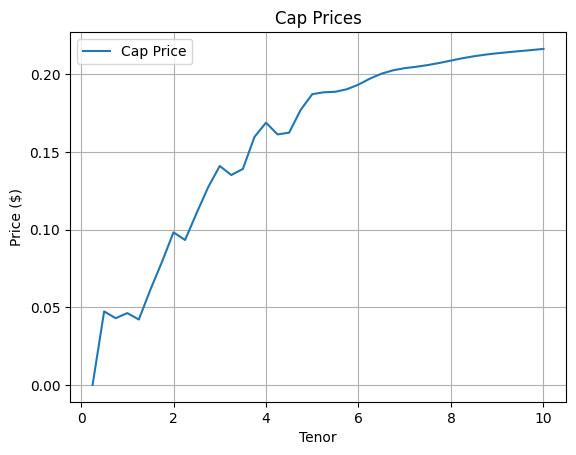

In [137]:
ax = caplets['price'].plot(linestyle='-', label='Cap Price')

plt.legend()
plt.xlabel('Tenor')
plt.ylabel('Price ($)')
plt.title('Cap Prices')
plt.grid()
plt.show()

### 3.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [138]:
stripped_cap = caplets[["price"]].copy()
stripped_cap.head()

,price
0.25,0
0.50,0.047331
0.75,0.04298
1.00,0.046265
1.25,0.04214


In [139]:
# Strip Out = Difference between current and previous cap price
stripped_cap["price"] = caplets["price"].diff()

# First Caplet Price is the first Cap Price
stripped_cap["price"] = stripped_cap["price"].fillna(caplets["price"])

# Ensure caplet prices are non-negative (force floor at zero)
stripped_cap["price"] = stripped_cap["price"].apply(lambda x: max(x, 0))

stripped_cap

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_44246/1383715504.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stripped_cap["price"] = stripped_cap["price"].fillna(caplets["price"])


,price
0.25,0.000000
0.50,0.047331
0.75,0.000000
1.00,0.003285
1.25,0.000000
1.50,0.019195
1.75,0.017844
2.00,0.019092
2.25,0.000000
2.50,0.017361


In [140]:
def cap_vol_to_price(flatvol, strike, fwds, discounts, dt=.25, notional=100):
    T = discounts.index[-1]
    flatvalues = pd.Series(dtype=float, index=discounts.index, name='flat values')
    
    tprev = discounts.index[0]
    for t in discounts.index[1:]:
        flatvalues.loc[t] = notional * dt * blacks_formula(tprev, flatvol, strike, fwds.loc[t], discounts.loc[t])
        tprev = t
        
    capvalue = flatvalues.sum()        
    return capvalue

# Using Helper Function
def blacks_formula(T,vol,strike,fwd,discount=1,isCall=True):
    sigT = vol * np.sqrt(T)
    d1 = (1/sigT) * np.log(fwd/strike) + .5*sigT
    d2 = d1-sigT
    
    if isCall:
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val

def price_caplet(T_rateset,vol,strike,fwd,discount,freq=4,notional=100):
    dt = 1/freq
    price = notional * dt * blacks_formula(T_rateset, vol, strike, fwd, discount, isCall=True)
    return price

def price_floorlet(T_rateset,vol,strike,fwd,discount,freq=4,notional=100):
    dt = 1/freq
    price = notional * dt * blacks_formula(T_rateset, vol, strike, fwd, discount, isCall=False)
    return price


def flat_to_forward_vol_rev(flatvols,strikes,fwds, discounts, freq=None, notional=100, returnCaplets=False):
#TODO: allow for timegrid to differ from cap timing
    if freq!=4:
        display('Warning: freq parameter controls timegrid and cap timing.')
        
    dt = 1/freq
    
    out = pd.DataFrame(dtype=float, index=flatvols.index, columns=['fwd vols','cap prices'])
    caplets = pd.DataFrame(dtype=float, index=flatvols.index, columns=strikes.values)

    first_cap = flatvols.index.get_loc(2*dt)

    for step, t in enumerate(flatvols.index):
        if step < first_cap:
            out.loc[t,'cap prices'] = np.nan
            out.loc[t,'fwd vols'] = np.nan
            tprev = t
        else:
            out.loc[t,'cap prices'] = cap_vol_to_price(flatvols.loc[t], strikes.loc[t], fwds.loc[:t], discounts.loc[:t], dt=dt, notional=notional)
            if step==first_cap:
                out.loc[t,'fwd vols'] = flatvols.loc[t]
                caplets.loc[t,strikes.loc[t]] = out.loc[t,'cap prices']
                tprev = t
            else:
                strikeT = strikes.loc[t]

                for j in flatvols.index[first_cap:step]:
                    caplets.loc[j,strikeT] = price_caplet(j-dt, out.loc[j,'fwd vols'], strikeT, fwds.loc[j], discounts.loc[j],freq=freq, notional=notional)

                caplets.loc[t,strikeT] = out.loc[t,'cap prices'] - caplets.loc[:tprev,strikeT].sum()

                wrapper = lambda vol: caplets.loc[t,strikeT] - price_caplet(tprev, vol, strikeT, fwds.loc[t], discounts.loc[t],freq=freq, notional=notional)

                out.loc[t,'fwd vols'] =  fsolve(wrapper,out.loc[tprev,'fwd vols'])[0]            
                tprev = t            

    out.insert(0,'flat vols',flatvols)
    
    if returnCaplets:
        return out, caplets
    else:
        return out


In [141]:
flatvols = curvedata['flat vols']
strikes = curvedata['swap rates']
fwds = curvedata['forwards']
discounts = curvedata['discounts']
freq = 4

vol_df = flat_to_forward_vol_rev(flatvols, strikes, fwds, discounts, freq, notional=100, returnCaplets=False)
vol_df

,flat vols,fwd vols,cap prices
tenor,,,
0.25,NaN,NaN,NaN
0.50,0.101500,0.101500,0.015175
0.75,0.116946,0.128478,0.045982
1.00,0.132391,0.154562,0.093612
1.25,0.159421,0.219138,0.170663
1.50,0.180856,0.239613,0.266562
1.75,0.197446,0.254106,0.378443
2.00,0.209941,0.261605,0.503493
2.25,0.219090,0.263323,0.633188


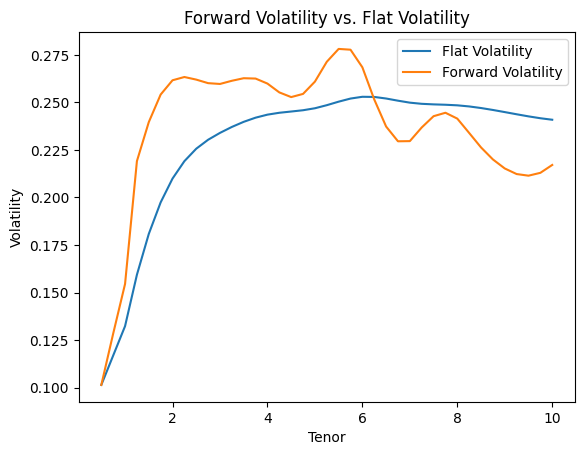

In [142]:
import matplotlib.pyplot as plt

plt.plot(vol_df.index, vol_df["flat vols"], label="Flat Volatility")
plt.plot(vol_df.index, vol_df["fwd vols"], label="Forward Volatility")

plt.xlabel("Tenor")
plt.ylabel("Volatility")
plt.legend()
plt.title("Forward Volatility vs. Flat Volatility")
plt.show()


***